### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12452
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[00 53 40 52 A0 5...|1995.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[08 59 08 59 B0 5...|1996.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[E0 58 B0 58 28 5...|1997.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[50 57 F0 56 A0 5...|1998.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[28 58 80 58 50 5...|1999.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [4]:
Query="SELECT latitude,longitude FROM weather\n\t"
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
lat,lon = [],[]
for row in df1.collect():
    lat.append(row[0])
    lon.append(row[1])

AnalysisException: u'Table or view not found: weather; line 1 pos 31'

In [27]:
%matplotlib inline
import gmplot
gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 100)
gmap.scatter(lat, lon, marker=True,color='red')
# gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
# gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
# gmap.heatmap(heat_lats, heat_lngs)
gmap.draw("mymap.html")

In [28]:
from IPython.display import IFrame
IFrame('./mymap.html', width=700, height=350)

In [5]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT distinct measurement FROM weather\n\t"
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)

SELECT distinct measurement FROM weather
	
6 rows
+-----------+
|measurement|
+-----------+
|       TMIN|
|       TOBS|
|       TMAX|
|       SNOW|
|       SNWD|
|       PRCP|
+-----------+



In [6]:
Query="SELECT max(latitude),min(latitude),max(longitude),min(longitude) FROM weather\n\t"
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)

1 rows
+-------------+-------------+--------------+--------------+
|max(latitude)|min(latitude)|max(longitude)|min(longitude)|
+-------------+-------------+--------------+--------------+
|      38.2103|      37.4833|     -120.8667|        -123.0|
+-------------+-------------+--------------+--------------+



### Select data for a particular station and measurement type

In [7]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USR0000CBRI')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USR0000CBRI'
14 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[00 53 40 52 A0 5...|1995.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[08 59 08 59 B0 5...|1996.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(14, 365)

### Script for plotting yearly plots

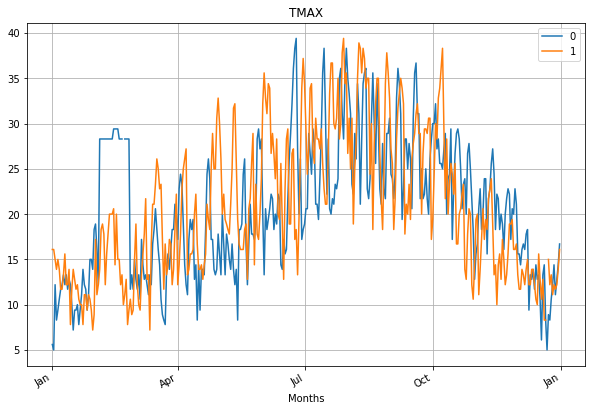

In [8]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMAX',xlabel='Months',ylabel='')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [9]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/kumaran/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


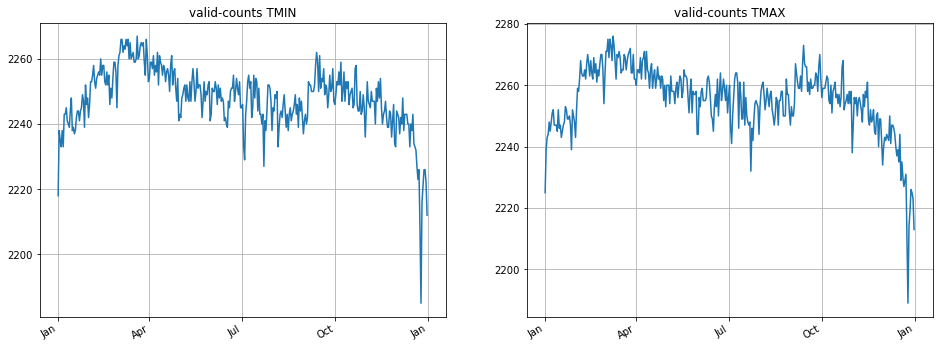

In [38]:
plot_pair(['TMIN','TMAX'],plot_valid)

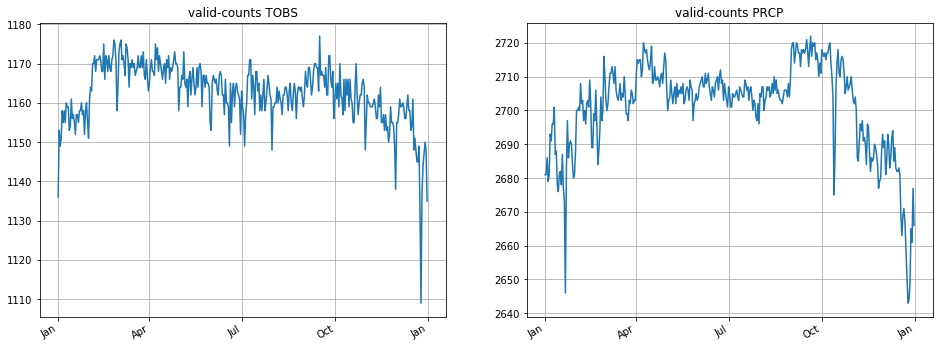

In [39]:
plot_pair(['TOBS','PRCP'],plot_valid)

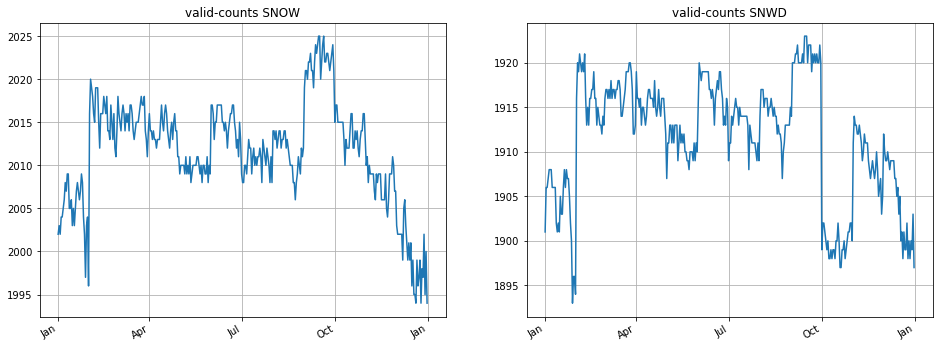

In [40]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [41]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    print np.mean(mean)
    std=np.sqrt(STAT[m]['Var'])
   
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,labels=['Mean-std', 'Mean', 'Mean+std'],title='Mean+-std   '+m,ylabel='Precipitation in mm/day')

In [15]:
from scipy.stats import ks_2samp
monthly_tmin_avg = []
month_tmin_real = [3.7,5.8,7.4,9,11.9,14.4,15.2,14.8,14.1,11.3,7.3,3.8]
i = 0
while i < 360:
    monthly_tmin_avg.append(sum(STAT['TMIN']['Mean'][i:i+30]/10.0)/30.0)
    i+=30
ks_2samp(month_tmin_real,monthly_tmin_avg)    

Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.43330893681048599)

In [16]:
monthly_tmax_avg = []
month_tmax_real = [12.2,15.6,18.6,21.9,26.2,30.1,33,32.2,30,24.9,17.7,12.4]
i = 0
while i < 360:
    monthly_tmax_avg.append(sum(STAT['TMAX']['Mean'][i:i+30]/10.0)/30.0)
    i+=30
ks_2samp(month_tmax_real,monthly_tmax_avg)    

Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.43330893681048599)

89.3160705341
208.605796477


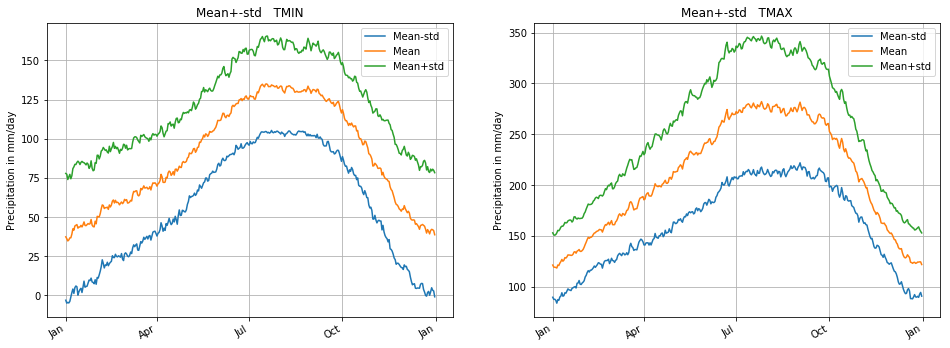

In [42]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

147.165000453
13.3147024191


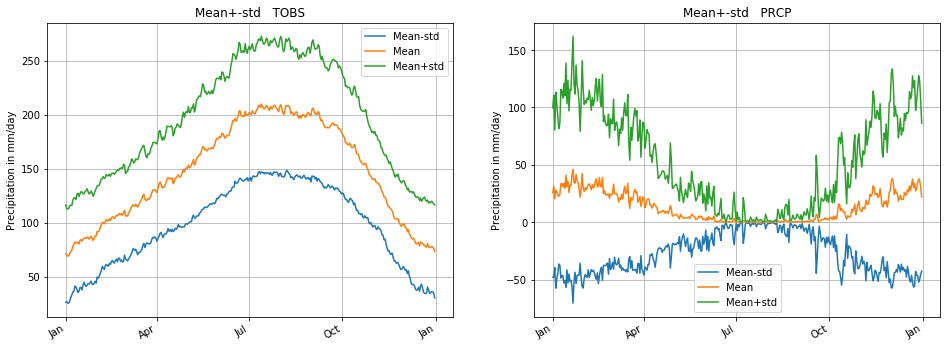

In [43]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

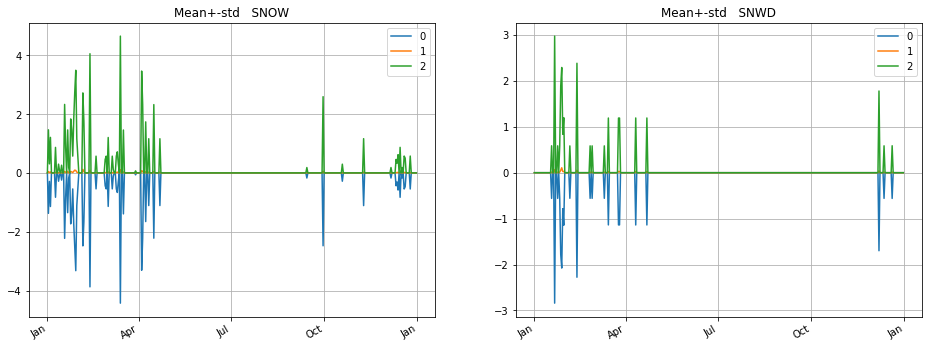

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [21]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:5],fig,axis,title='Top Eigenvectors '+m)

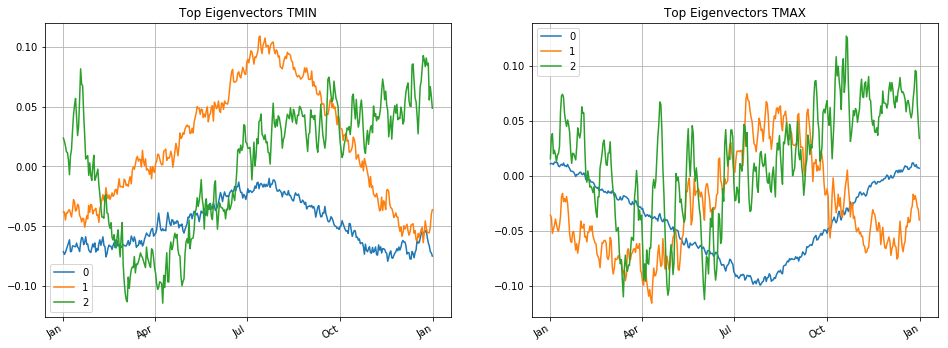

In [17]:
plot_pair(['TMIN','TMAX'],plot_eigen)

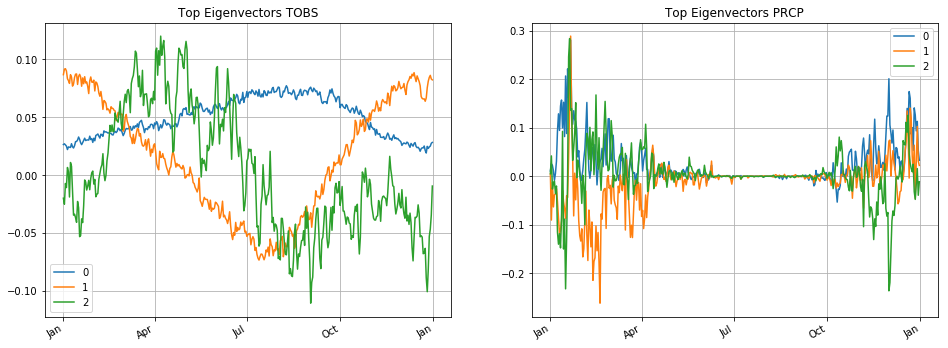

In [18]:
plot_pair(['TOBS','PRCP'],plot_eigen)

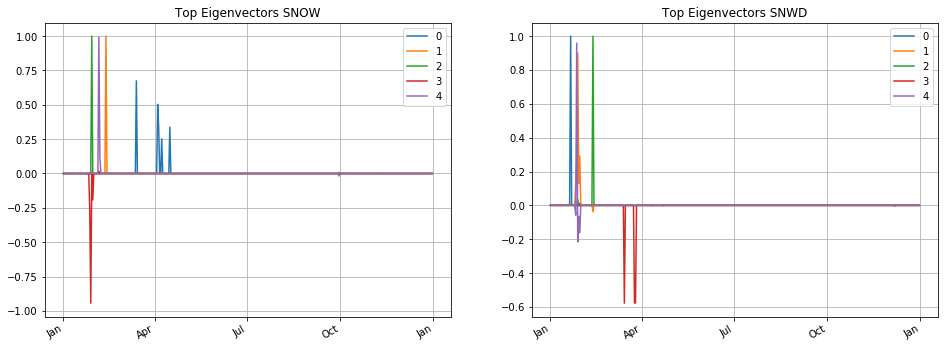

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [14]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

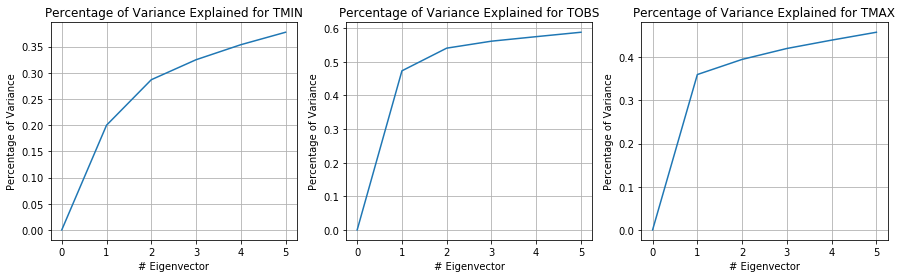

In [15]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

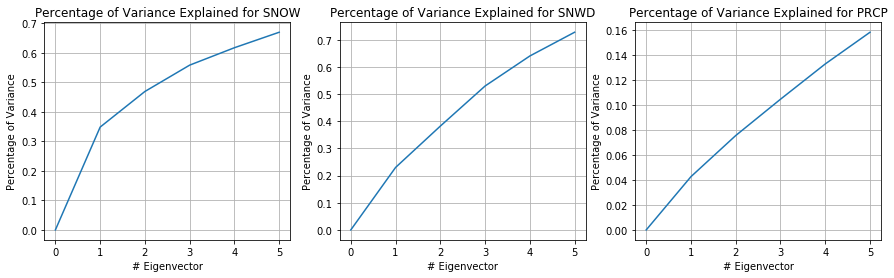

In [16]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()

In [45]:
sum(STAT['PRCP']['Mean'][0:30])/30

31.703405981712635

In [44]:
len(STAT['PRCP']['Mean'][0:30])

30